### Import data and packages, replacing problematic values with NaNs so that they can be filled dynamically more easily

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [4]:
results = pd.read_csv('results.csv').replace('\\N', np.NaN)

Conduct initial linear regression of grid position on finishing position in F1 races.  In this instance, those who do not finish a race will be given the same result as the last place result of the finishers.

In [6]:
final = results['position'].fillna(method = 'ffill')
grid = results[['grid']]

In [7]:
mod = LinearRegression()
mod.fit(grid, final)
dnf_coef = mod.coef_
dnf_score = mod.score(grid, final)
dnf_int = mod.intercept_

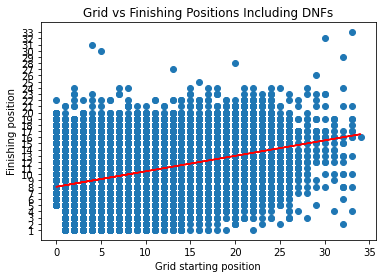

In [8]:
plt.plot(grid, final, 'o')
plt.xlabel('Grid starting position')
plt.ylabel('Finishing position')
plt.title("Grid vs Finishing Positions Including DNFs")
plt.plot(grid,dnf_coef*grid + dnf_int, 'r')

In [12]:
dnf_score

0.14481453758010687

Now, the same analysis is conducted but in this case when a driver does not finish a race, their result is removed from the regression.

In [9]:
new_grid = results[['grid']][results['position'].str.isnumeric()==True]
new_final = results['position'][results['position'].str.isnumeric()==True]

Text(0.5, 1.0, 'Distribution of finishes')

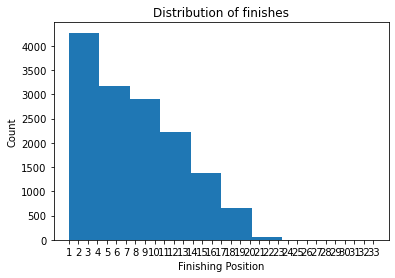

In [11]:
plt.hist(new_final)
plt.ylabel("Count")
plt.xlabel("Finishing Position")
plt.title("Distribution of finishes")

In [8]:
mod = LinearRegression()
mod.fit(new_grid, new_final)
new_coef = mod.coef_
new_score = mod.score(new_grid, new_final)
new_int = mod.intercept_

In [9]:
new_score

0.41662692496163667

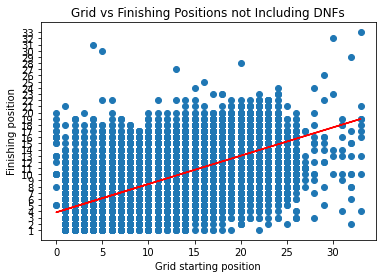

In [10]:
plt.plot(new_grid, new_final, 'o')
plt.xlabel('Grid starting position')
plt.ylabel('Finishing position')
plt.title("Grid vs Finishing Positions not Including DNFs")
plt.plot(new_grid,new_coef*new_grid + new_int, 'r')

This model is a massive improvement over the original.  This is likely because a lot of drivers do not finish the race and this may have very little to do with their ability to finish in a top spot.  The hypothesis here is that the causes of DNF--primarily failures and crashes--generally occur to all drivers at a roughly similar rate.

That said, there is still considerable room for improvement.  Now, new variables will be added to analyze their impact on the outcome.

In [14]:
variables = results[['grid', 'rank']][results['rank'].str.isnumeric()==True]
finals_rank = results['position'][results['rank'].str.isnumeric()==True].fillna(method = 'ffill')

In [15]:
mod = LinearRegression()
mod.fit(variables, finals_rank)
mod.coef_
mod.score(variables, finals_rank)

0.5239834109139275

This model performs a bit better, but there is still quite a bit of improvement to make.  The next step is bringing in information about the driver.  Hopefully, this will yield better results.

In [16]:
# import the driver_standings data and combine with results data
driver_standings = pd.read_csv('driver_standings.csv').replace('\\N', np.NaN)

In [17]:
joined = results.join(driver_standings, on='driverId', how = 'inner', rsuffix = "_standings")

In [18]:
#run regression just like in previous model, but including wins
griddy_wins = joined[['grid', 'wins']][joined['position'].str.isnumeric()==True]
finishes = joined['position'][joined['position'].str.isnumeric()==True]

In [19]:
modelo = LinearRegression()
modelo.fit(griddy_wins, finishes)
modelo.coef_
modelo.score(griddy_wins, finishes)

0.41778213834613653

The addition of wins does not meaningfully improve the model as the data is so sparse.  Importantly, we must find another way to quantify previous driver performance in the model.  To do this, we replace the wins variable with points.

In [20]:
griddy_points = joined[['grid', 'points']][joined['position'].str.isnumeric()==True]

In [21]:
modelo.fit(griddy_points, finishes)
modelo.coef_
modelo.score(griddy_points, finishes)

0.5376952086353629

In [22]:
np.corrcoef(griddy_points['grid'], griddy_points['points'])

array([[ 1.        , -0.55103888],
       [-0.55103888,  1.        ]])

While the addition of points to grid position gives us our best model yet, the addition is a bit underwhelming as grid position and the number of points a driver has are correlated.  This makes sense since they are both variables measuring performance.  We now will test whether logistic regression can predict which driver will win.  To do this, we create a binary variable for whether a driver won or not.

In [23]:
winner = []
for i in results['position']:
    if i == '1':
        winner.append(1)
    else:
        winner.append(0)
results['winner'] = winner

In [25]:
new_joined = results.join(driver_standings, on='driverId', how = 'inner', rsuffix = "_standings")

In [26]:
split = round(int(new_joined.loc[new_joined['position'].str.isnumeric()==True].shape[0] * 0.8))
new_griddy_points = new_joined[['grid', 'points_standings']][new_joined['position'].str.isnumeric()==True]
train_griddy = new_griddy_points[:split]
test_griddy = new_griddy_points[split:]

did_win = new_joined[['winner']][new_joined['position'].str.isnumeric()==True]
train_win = did_win[:split]
test_win = did_win[split:]

In [27]:
from sklearn.linear_model import LogisticRegression
logs = LogisticRegression()
logs.fit(train_griddy, train_win)
logs.coef_

C:\Users\jherb\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([[-0.50323399,  0.01010991]])

In [31]:
logs.score(test_griddy, test_win)

0.9652233208319128

Converting the model to a logistic binary one has drastically improved model performance.  The starting grid position and number of points may not overall be great predictors at finishing position, but they are good at predicting who will win a given race. This suggests that there is often a 'best' driver which is a clear favorite.  To check our intuition on this, we will now compare grid position with win result.

<AxesSubplot:xlabel='points_standings', ylabel='winner'>

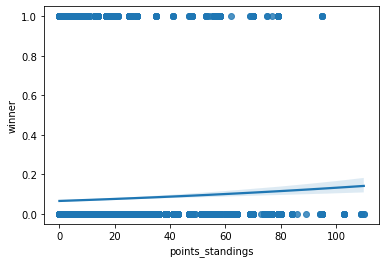

In [149]:
sns.regplot(x = new_griddy_points['points_standings'],y = did_win,logistic = True)

<AxesSubplot:xlabel='grid', ylabel='winner'>

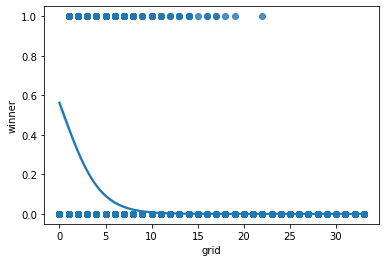

In [78]:
sns.regplot(x = new_griddy_points['grid'],y = did_win,logistic = True)

This section tests how often the model correctly guesses whether a driver wins a race or not

In [211]:
def accuracy(win_true, win_pred):
    return np.mean(np.array(win_true) == np.array(win_pred))

In [220]:
pred = logs.predict(test_griddy)

In [236]:
accuracy(test_win, pred)

0.9630864974079013

So far, the model has worked even better than expected with the training data, at least that is how it appears.  Now, we conduct the same analysis, bur this time predicting whether a driver placed podium(finished first, second or third).

In [223]:
did_place = []

for i in results['position']:
    if i == '3' or i == '2' or i=='1':
        did_place.append(1)
    else:
        did_place.append(0)
results['placed'] = did_place

In [242]:
placed = results['placed'][new_joined['position'].str.isnumeric()==True]
train_placed = placed[:split]
test_placed = placed[split:]

In [228]:
logs.fit(train_griddy, train_placed)
logs.coef_

array([[0.00429102, 0.00187787]])

In [229]:
logs.score(train_griddy, train_placed)

0.7708439897698209

<AxesSubplot:xlabel='points_standings', ylabel='placed'>

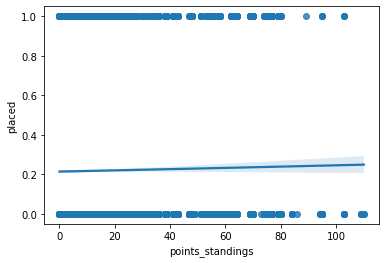

In [230]:
sns.regplot(x = new_griddy_points['points_standings'],y = placed,logistic = True)

<AxesSubplot:xlabel='grid', ylabel='placed'>

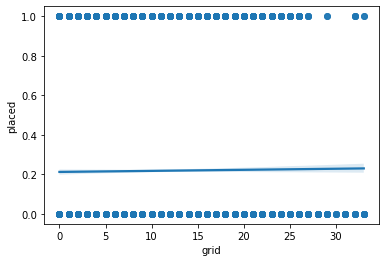

In [232]:
sns.regplot(x = new_griddy_points['grid'],y = placed,logistic = True)

In [231]:
place_pred = logs.predict(test_griddy)

In [243]:
accuracy(test_placed, place_pred)

0.8250937606546198